In [1]:
import os
from math import pi

os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, NFWParams, PlummerParams, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot

import timeit


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=10_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                 r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                 c = 10,),
                          G=G, ) 


# Direct ACC

In [ ]:
runtime_list_direct_acc = []
N_particles_list = [1_000_000]
for N_particles in N_particles_list:

    config = SimulationConfig(N_particles=N_particles, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

    params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                            Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                            a=(1 * u.kpc).to(code_units.code_length).value),
                            NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                    r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                    c = 10,),
                            G=G, ) 
    
    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(4), params=params, config=config)
    #put the Plummer sphere in a ciruclar orbit around the NFW halo
    rp=100*u.kpc.to(code_units.code_length)

    mass_inside_rp = 4*jnp.pi*params.NFW_params.d_c*params.NFW_params.r_s**3*(jnp.log(1+rp/params.NFW_params.r_s)-rp/(rp+params.NFW_params.r_s))

    if len(config.external_accelerations)>0:
        pos, vel, _ = ic_two_body(mass_inside_rp, params.Plummer_params.Mtot, rp=rp, e=0., config=config, params=params)
        velocities = velocities + vel[1]
        positions = positions + pos[1]

    #initialize the initial state
    initial_state = construct_initial_state(positions, velocities)
    
    snapshots = jax.block_until_ready( time_integration(initial_state, mass, config, params) )
    # Where you're currently using timeit.timeit()
    times = timeit.repeat(
        lambda: jax.block_until_ready(time_integration(initial_state, mass, config, params)),
        repeat=3,  # Number of times to repeat the measurement
        number=2   # Number of calls per measurement
    )

    mean_runtime = np.mean(times)
    std_runtime = np.std(times)
    runtime_list_direct_acc.append((mean_runtime, std_runtime))

# DIRECT ACC MASKING

In [5]:
runtime_list_direct_acc_matrix = []
N_particles_list = [50, 100, 500, 1_000, 5_000, 10_000, 50_000, 100_000]
for N_particles in N_particles_list:

    config = SimulationConfig(N_particles=N_particles, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC_MATRIX,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

    params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                            Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                            a=(1 * u.kpc).to(code_units.code_length).value),
                            NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                    r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                    c = 10,),
                            G=G, ) 
    
    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(4), params=params, config=config)
    #put the Plummer sphere in a ciruclar orbit around the NFW halo
    rp=100*u.kpc.to(code_units.code_length)

    mass_inside_rp = 4*jnp.pi*params.NFW_params.d_c*params.NFW_params.r_s**3*(jnp.log(1+rp/params.NFW_params.r_s)-rp/(rp+params.NFW_params.r_s))

    if len(config.external_accelerations)>0:
        pos, vel, _ = ic_two_body(mass_inside_rp, params.Plummer_params.Mtot, rp=rp, e=0., config=config, params=params)
        velocities = velocities + vel[1]
        positions = positions + pos[1]

    #initialize the initial state
    initial_state = construct_initial_state(positions, velocities)
    
    snapshots = jax.block_until_ready( time_integration(initial_state, mass, config, params) )
    # Where you're currently using timeit.timeit()
    times = timeit.repeat(
        lambda: jax.block_until_ready(time_integration(initial_state, mass, config, params)),
        repeat=3,  # Number of times to repeat the measurement
        number=2   # Number of calls per measurement
    )

    mean_runtime = np.mean(times)
    std_runtime = np.std(times)
    runtime_list_direct_acc_matrix.append((mean_runtime, std_runtime))

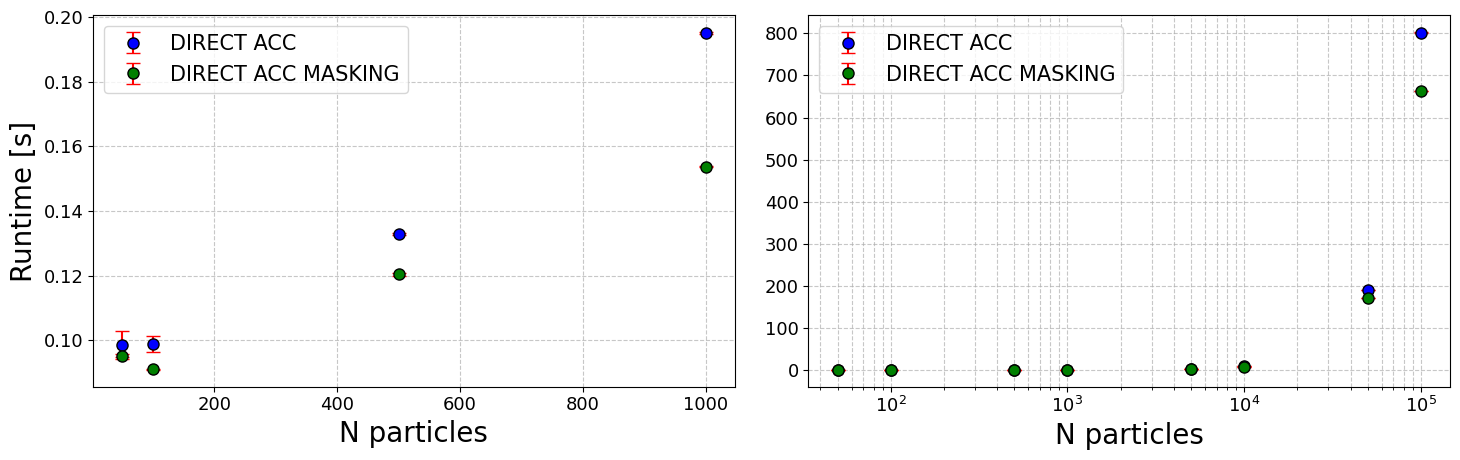

In [12]:
# Extract mean and std from runtime_list tuples
mean_times_acc = [t[0] for t in runtime_list_direct_acc]
std_times_acc = [t[1] for t in runtime_list_direct_acc]

mean_times_acc_masking = [t[0] for t in runtime_list_direct_acc_matrix]
std_times_acc_masking = [t[1] for t in runtime_list_direct_acc_matrix]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax = fig.add_subplot(122)
# Create an error bar plot
ax.errorbar(N_particles_list, mean_times_acc, yerr=std_times_acc, fmt='o', capsize=5, 
             markersize=8, ecolor='red', markeredgecolor='black', markerfacecolor='blue', label='DIRECT ACC')
ax.errorbar(N_particles_list, mean_times_acc_masking, yerr=std_times_acc_masking, fmt='o', capsize=5,
                markersize=8, ecolor='red', markeredgecolor='black', markerfacecolor='green', label='DIRECT ACC MASKING')

# Set scales and labels
ax.set_xscale('log')
ax.set_xlabel('N particles')
# ax.set_ylabel('Runtime [s]')
ax.grid(True, which="both", ls="--", alpha=0.7)
ax.legend()


ax = fig.add_subplot(121)
# Create an error bar plot
ax.errorbar(N_particles_list[:4], mean_times_acc[:4], yerr=std_times_acc[:4], fmt='o', capsize=5, 
             markersize=8, ecolor='red', markeredgecolor='black', markerfacecolor='blue', label='DIRECT ACC')
ax.errorbar(N_particles_list[:4], mean_times_acc_masking[:4], yerr=std_times_acc_masking[:4], fmt='o', capsize=5,
                markersize=8, ecolor='red', markeredgecolor='black', markerfacecolor='green', label='DIRECT ACC MASKING')

# Set scales and labels
# ax.set_xscale('log')
ax.set_xlabel('N particles')
ax.set_ylabel('Runtime [s]')
ax.grid(True, which="both", ls="--", alpha=0.7)
ax.legend()

fig.savefig('runtime_direct_acc_vs_direct_acc_matrix.pdf')

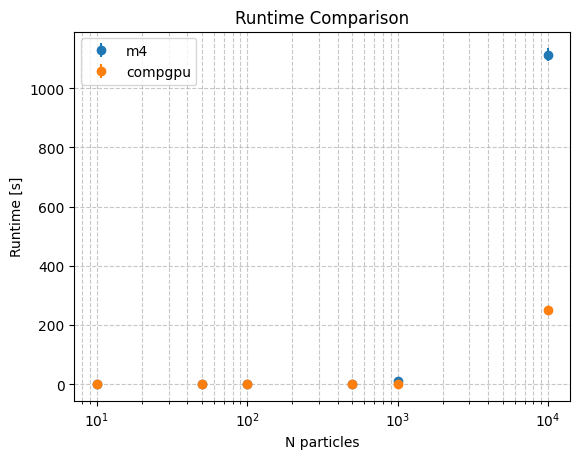

In [11]:
import numpy as np
import matplotlib.pyplot as plt

N_particles_list = [10, 50, 100, 500, 1_000, 10_000]

data_m4 = np.load('./kartick_test_data/m4test.npy')
data_compgpu = np.load('./kartick_test_data/compgpu4.npy')

plt.errorbar(N_particles_list, data_m4[:, 0], data_m4[:, 1], fmt='o', label='m4')
plt.errorbar(N_particles_list, data_compgpu[:, 0], data_compgpu[:, 1], fmt='o', label='compgpu')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('N particles')
plt.ylabel('Runtime [s]')
plt.title('Runtime Comparison')
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.legend()

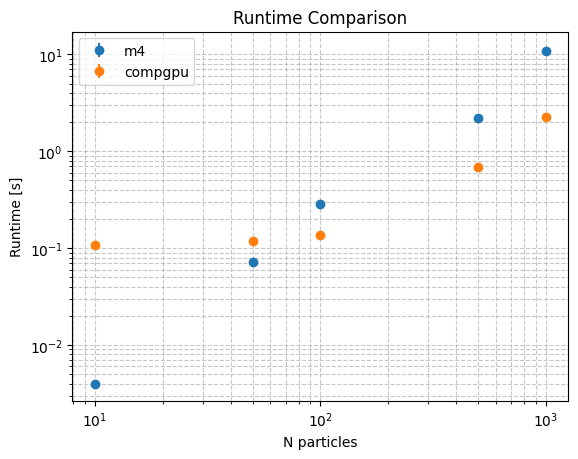

In [13]:
import numpy as np
import matplotlib.pyplot as plt

N_particles_list = [10, 50, 100, 500, 1_000, ]

data_m4 = np.load('./kartick_test_data/m4test.npy')
data_compgpu = np.load('./kartick_test_data/compgpu4.npy')

plt.errorbar(N_particles_list, data_m4[:-1, 0], data_m4[:-1, 1], fmt='o', label='m4')
plt.errorbar(N_particles_list, data_compgpu[:-1, 0], data_compgpu[:-1, 1], fmt='o', label='compgpu')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N particles')
plt.ylabel('Runtime [s]')
plt.title('Runtime Comparison')
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.legend()